In [1]:
!pip uninstall -y scipy numpy tensorflow tensorflow-addons
!pip install numpy==1.23.5
!pip install scipy==1.10.1
!pip install tensorflow==2.12.0
!pip install tensorflow-addons==0.20.0
!pip uninstall -y tf-keras
!pip install tf-keras==2.12.0
!pip install conllu
!pip install gensim
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install pyarabic camel-tools

Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 104.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.11.0 requires scipy>=1.6.0, which is not installed.
fastai 2.7.19 requires scipy, which is not installed.
jax 0.5.2 requires scipy>=1.11.1, which is not installed.
scikit-learn 1.6.1 requires scipy>=1.6.0, which is not installed.
sklearn-pandas 2.2.0 requires scipy>=1.5.1, which is not installed.
scikit-image 0.25.2 requires scipy>=1.11.4, which is not installed.
jaxlib 0.5.1 requires scipy>=1.11.1, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
ja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 46.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
INFO: pip is looking at multiple versions of jax to determine w

Importation des bibliothèques nécessaires

In [1]:
import conllu
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.downloader import load
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.layers import CRF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Conv1D, Dropout, concatenate
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pyarabic.araby as araby
from camel_tools.utils.normalize import normalize_unicode
from tensorflow.keras.metrics import Precision, Recall

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


connection avec google drive pour le sauvegarde

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importation et affichage du dataset

In [3]:
with open("/content/drive/MyDrive/ar_padt-ud-dev.conllu", mode="r", encoding="utf-8") as data:
    annotations=data.read()

sentences = conllu.parse(annotations)
sentences[1][0]

{'id': 1,
 'form': 'لونغ',
 'lemma': 'لُونغ',
 'upos': 'X',
 'xpos': 'X---------',
 'feats': {'Foreign': 'Yes'},
 'head': 0,
 'deprel': 'root',
 'deps': [('root', 0)],
 'misc': {'Vform': 'لُونغ',
  'Gloss': 'Long',
  'Root': 'lUn.g',
  'Translit': 'lūnġ',
  'LTranslit': 'lūnġ'}}

Création d'un DataFrame contenant l'id de la phrase, l'id des mots, le mot et son étiquette


In [ ]:
data = []
current_sentence_id = None

with open("/content/drive/MyDrive/ar_padt-ud-dev.conllu", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()

        if line.startswith("# sent_id"):
            current_sentence_id = line.split("=")[-1].strip()

        elif line and not line.startswith("#"):
            parts = line.split("\t")
            if len(parts) >= 4 and parts[0].isdigit():
                word_id = int(parts[0])
                word = parts[1]
                upos = parts[3]
                data.append((current_sentence_id, word_id, word, upos))

df1 = pd.DataFrame(data, columns=["sentence_id", "word_id", "w_name", "tag_name"])

Affichage et visualisation des catégories d'étiquettes

[Text(0, 0, '9612'),
 Text(0, 0, '4410'),
 Text(0, 0, '2916'),
 Text(0, 0, '2882'),
 Text(0, 0, '2318'),
 Text(0, 0, '2041'),
 Text(0, 0, '2018'),
 Text(0, 0, '1211'),
 Text(0, 0, '969'),
 Text(0, 0, '625'),
 Text(0, 0, '555'),
 Text(0, 0, '270'),
 Text(0, 0, '258'),
 Text(0, 0, '108'),
 Text(0, 0, '27'),
 Text(0, 0, '18'),
 Text(0, 0, '1')]

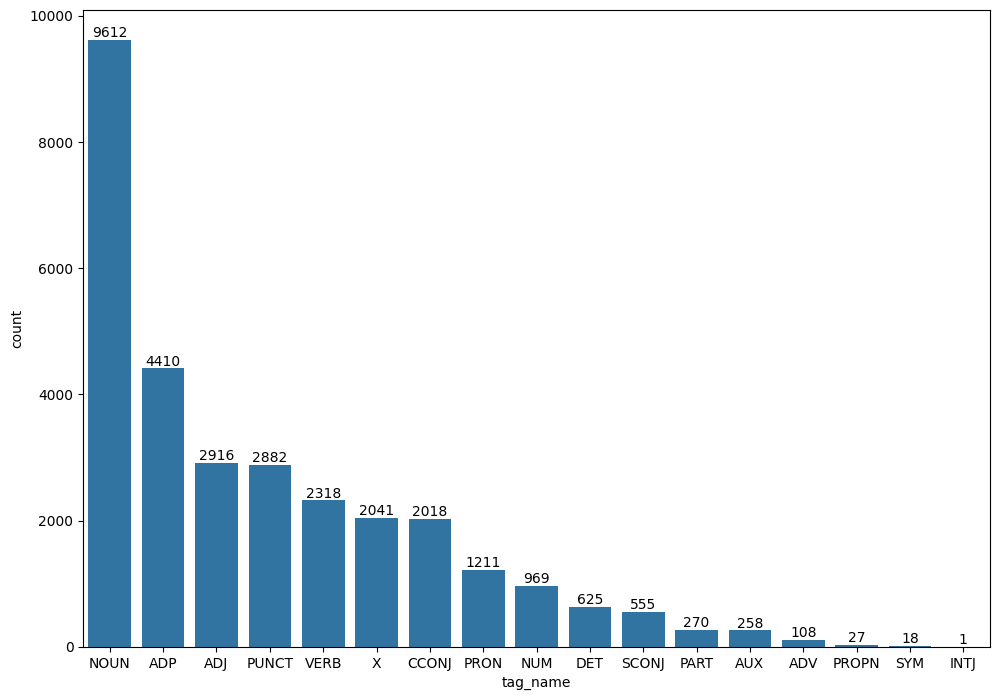

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(x=df1['tag_name'],order=df1['tag_name'].value_counts(ascending=False).index)
abs_values = df1['tag_name'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

Fonction qui permet de supprimer le Tashkeel au mots et les signes coraniques

In [ ]:
def normalize_arabic_text(text):

    if not isinstance(text, str):
        return text

    text = normalize_unicode(text)

    text = araby.strip_tashkeel(text)

    text = araby.normalize_alef(text)

    text = araby.normalize_hamza(text)

    text = araby.normalize_ligature(text)

    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    text = re.sub(r'\s+', ' ', text)

    return text.strip()

Nettoyage (Pre-Processing) du dataset en ne gardant que les mots en arabe, en supprimant Tashkeel et on garde le POS


In [ ]:
grouped = df1.groupby("sentence_id")

corpus = []
list_pos = []
list_words = []
pos = []
list_sentences = []

re_pattern = re.compile(r'[a-zA-Z]+')

for sentence_id, group in grouped:
    sentence_txt = " ".join(group['w_name'].tolist())
    normalized_sentence = normalize_arabic_text(sentence_txt)

    if re_pattern.search(normalized_sentence) is None:
        list_sentences.append(normalized_sentence)
        word_dict = {}
        pos_bfr = []

        for idx, row in group.iterrows():
            word_str = normalize_arabic_text(row['w_name'])
            word_pos = row['tag_name']

            list_words.append(word_str)
            list_pos.append(word_pos)
            pos_bfr.append(word_pos)

            word_dict[int(row['word_id'])] = [word_str, word_pos]

        corpus.append(word_dict)
        pos.append(pos_bfr)


Création du dataframe frame final aprés pre-processing

In [ ]:
rows = []

for sentence_idx, word_dict in enumerate(corpus):
    sentence_text = list_sentences[sentence_idx]
    for word_id, (word_str, word_pos) in word_dict.items():
        rows.append({
            "sentence_id": sentence_idx, 
            "w_name": word_str,
            "tag_name": word_pos,
        })

final_df = pd.DataFrame(rows)


In [9]:
final_df.head()

,sentence_id,w_name,tag_name
0,0,و,CCONJ
1,0,قالت,VERB
2,0,روث,X
3,0,شوارتز,X
4,0,التي,DET


Sauvegarde du dataframe dans le drive

In [10]:
final_df.to_csv("/content/drive/MyDrive/POS_dataset.csv", encoding="utf-8")

Création de variables contenant les phrases et les étiquettes

In [11]:
sentences = grouped["w_name"].apply(list).tolist()
tags = grouped["tag_name"].apply(list).tolist()

Encodage des mots et des étiquettes en mappant chaque mot avec son id pour faciliter leur manipulation


In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(set(final_df["w_name"]))}
word2idx["UNK"] = 1
word2idx["PAD"] = 0

tag2idx = {t: i for i, t in enumerate(set(final_df["tag_name"]))}
idx2tag = {i: t for t, i in tag2idx.items()}
n_tags = len(tag2idx)

X = [[word2idx.get(w, 1) for w in s] for s in sentences]
y = [[tag2idx[t] for t in s] for s in tags]

print(idx2tag)


{0: 'SYM', 1: 'ADP', 2: 'PUNCT', 3: 'DET', 4: 'ADV', 5: 'NOUN', 6: 'CCONJ', 7: 'INTJ', 8: 'X', 9: 'PROPN', 10: 'VERB', 11: 'ADJ', 12: 'NUM', 13: 'PART', 14: 'AUX', 15: 'SCONJ', 16: 'PRON'}


In [58]:
import pickle

with open('/content/drive/MyDrive/word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

with open('/content/drive/MyDrive/idx2label.pkl', 'wb') as f:
    pickle.dump(idx2tag, f)

with open('/content/drive/MyDrive/label2idx.pkl', 'wb') as f:
    pickle.dump(tag2idx, f)

In [ ]:
def extract_features(word):
    features = []

    contains_digit = [1] if any(c.isdigit() for c in word) else [0]
    is_digit = [1] if word.isdigit() else [0]

    is_punct = [1] if all(not c.isalnum() for c in word) else [0]

    suffix = word[-3:].ljust(3)
    suffix_features = [ord(c) / 1200 for c in suffix]  

    prefix = word[:3].ljust(3)
    prefix_features = [ord(c) / 1200 for c in prefix]

    length = [min(len(word) / 15, 1.0)]
    has_alef = [1] if 'ا' in word else [0]
    has_waw = [1] if 'و' in word else [0]
    has_yeh = [1] if 'ي' in word else [0]

    features = (contains_digit + is_digit + is_punct + suffix_features +
               prefix_features + length + has_alef + has_waw + has_yeh)

    return features

In [14]:
def extract_features_for_sentence(sentence):
    features = []
    for word in sentence:
        features.append(extract_features(word))
    return features

Covertir toutes les sequences avec la même longueur qui est celle de la séquence la plus longue

In [ ]:
MAXLEN = max(len(s) for s in sentences)
X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
X_padded = pad_sequences(X, maxlen=MAXLEN, padding="post", value=word2idx["PAD"])

X_features = []
for s in sentences:
    sent_features = extract_features_for_sentence(s)
    while len(sent_features) < MAXLEN:
        zeros_vector = [0] * len(extract_features(""))
        sent_features.append(zeros_vector)

    X_features.append(sent_features)

X_features=np.array(X_features)

y = [[tag2idx.get(t, tag2idx["X"]) for t in ts] for ts in tags]
y_padded = pad_sequences(y, maxlen=MAXLEN, padding="post", value=tag2idx["X"])




In [35]:
X_padded_train, X_padded_test, X_features_train, X_features_test, y_train, y_test = train_test_split(
    X_padded, X_features, y_padded, test_size=0.2, random_state=42
)

X_padded_train = tf.convert_to_tensor(X_padded_train)
X_padded_test = tf.convert_to_tensor(X_padded_test)
X_features_train = tf.convert_to_tensor(X_features_train)
X_features_test = tf.convert_to_tensor(X_features_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

Création du modèle BILSTTM avec une couche dense en transformant chaque vecteur en probabilité

In [ ]:
n_words = len(word2idx)
n_chars = len(char2idx)
n_features =  X_features_train.shape[2]

word_input = Input(shape=(MAXLEN,), name='word_input')
feature_input = Input(shape=(MAXLEN, n_features), name='feature_input')
word_embedding = Embedding(input_dim=n_words, output_dim=100,input_length=MAXLEN, mask_zero=True)(word_input)

merged = concatenate([word_embedding, feature_input])

main_lstm = Bidirectional(LSTM(units=100, return_sequences=True))(merged)
main_lstm = Dropout(0.5)(main_lstm)

output = TimeDistributed(Dense(n_tags, activation='softmax'))(main_lstm)

model = Model(inputs=[word_input, feature_input], outputs=output)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_input (InputLayer)        [(None, 112)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 112, 100)     637100      ['word_input[0][0]']             
                                                                                                  
 feature_input (InputLayer)     [(None, 112, 13)]    0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 112, 113)     0           ['embedding_4[0][0]',            
                                                                  'feature_input[0][0]']    

Conversion des données en tableaux Numpy pour faire le split puis leur reconversion en teneur TensorFlow et finalement entrainement du modèle

In [39]:
history = model.fit([X_padded_train,X_features_train], y_train, batch_size=32, epochs=20,validation_data=([X_padded_test, X_features_test], y_test),verbose=1)


Epoch 1/20
23/23 [==============================] - 17s 401ms/step - loss: 2.3171 - accuracy: 0.2910 - val_loss: 2.0176 - val_accuracy: 0.3594
Epoch 2/20
23/23 [==============================] - 6s 278ms/step - loss: 1.9454 - accuracy: 0.4160 - val_loss: 1.7016 - val_accuracy: 0.5395
Epoch 3/20
23/23 [==============================] - 6s 266ms/step - loss: 1.5606 - accuracy: 0.5552 - val_loss: 1.2478 - val_accuracy: 0.6270
Epoch 4/20
23/23 [==============================] - 6s 265ms/step - loss: 1.1246 - accuracy: 0.6621 - val_loss: 0.8975 - val_accuracy: 0.7113
Epoch 5/20
23/23 [==============================] - 6s 261ms/step - loss: 0.8172 - accuracy: 0.7531 - val_loss: 0.6710 - val_accuracy: 0.8069
Epoch 6/20
23/23 [==============================] - 6s 261ms/step - loss: 0.5886 - accuracy: 0.8395 - val_loss: 0.5242 - val_accuracy: 0.8594
Epoch 7/20
23/23 [==============================] - 6s 263ms/step - loss: 0.4382 - accuracy: 0.8914 - val_loss: 0.4325 - val_accuracy: 0.8804
Epoch

Evaluation et sauvegarde du modèle

In [40]:
results = model.evaluate([X_padded_test, X_features_test], y_test)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

model.save('/content/drive/MyDrive/modele')

6/6 [==============================] - 0s 36ms/step - loss: 0.3473 - accuracy: 0.8995
loss: 0.3473
accuracy: 0.8995


Création d'un modèle BILSTM avec une couche CNN

In [ ]:
from tensorflow.keras.layers import MaxPooling1D

n_words = len(word2idx)
n_chars = len(char2idx)
n_features =  X_features_train.shape[2]

word_input = Input(shape=(MAXLEN,), name='word_input')
feature_input = Input(shape=(MAXLEN, n_features), name='feature_input')
word_embedding = Embedding(input_dim=n_words, output_dim=100,input_length=MAXLEN, mask_zero=True)(word_input)

merged = concatenate([word_embedding, feature_input])

cnn_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(merged)
cnn_layer = Dropout(0.3)(cnn_layer)

main_lstm = Bidirectional(LSTM(units=100, return_sequences=True))(cnn_layer)
main_lstm = Dropout(0.5)(main_lstm)

output = TimeDistributed(Dense(n_tags, activation='softmax'))(main_lstm)

model1 = Model(inputs=[word_input, feature_input], outputs=output)

model1.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()

history = model1.fit(
    [X_padded_train,X_features_train],
    np.array(y_train),
    batch_size=100,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

results = model1.evaluate([X_padded_test,X_features_test], y_test)
for name, value in zip(model1.metrics_names, results):
    print(f"{name}: {value:.4f}")

model1.save('/content/drive/MyDrive/modele_BILSTM-CNN')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_input (InputLayer)        [(None, 112)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 112, 100)     637100      ['word_input[0][0]']             
                                                                                                  
 feature_input (InputLayer)     [(None, 112, 13)]    0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 112, 113)     0           ['embedding_4[0][0]',            
                                                                  'feature_input[0][0]']    

In [ ]:
def predict_pos_tags(sentence, model, word2idx, tag2idx, extract_features_for_sentence, extract_features, MAXLEN):
    idx2tag = {v: k for k, v in tag2idx.items()}

    words = sentence.split()

    X = [word2idx.get(w, word2idx.get("UNK", 0)) for w in words]
    X_padded = pad_sequences([X], maxlen=MAXLEN, padding="post", value=word2idx.get("PAD", 0))

    sent_features = extract_features_for_sentence(words)

    while len(sent_features) < MAXLEN:
        zeros_vector = [0] * len(extract_features(""))
        sent_features.append(zeros_vector)

    X_features = np.array([sent_features])

    predictions = model.predict([X_padded, X_features])

    pred_tags = []
    for i in range(min(len(words), MAXLEN)):
        pred_idx = np.argmax(predictions[0, i])
        if pred_idx in idx2tag:
            pred_tags.append(idx2tag[pred_idx])
        else:
            pred_tags.append(tag2idx.get("X", "UNK"))

    return pred_tags, words
sentence="ارتفع سعر النفط بنسبة 5% خلال 30 يوما الماضية"
predict_pos_tags(sentence,model1,word2idx,tag2idx,extract_features_for_sentence,extract_features,MAXLEN)

1/1 [==============================] - 0s 33ms/step


(['VERB', 'NOUN', 'NOUN', 'ADP', 'NUM', 'ADP', 'NUM', 'NOUN', 'ADJ'],
 ['ارتفع', 'سعر', 'النفط', 'بنسبة', '5%', 'خلال', '30', 'يوما', 'الماضية'])

Fine-tunning du modèle AraBert sur noss données pour la tâche de POS tagging

In [ ]:
class POSTaggingDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

def tokenize_and_align_labels(texts, tags, tokenizer):
    tokenized_inputs = tokenizer(texts, truncation=True, padding=True, is_split_into_words=False)

    labels = []

    for i, (text, tag) in enumerate(zip(texts, tags)):
        word_ids = tokenizer(text, truncation=True, is_split_into_words=False).word_ids()

        label = tag
        label_ids = [-100] * len(tokenized_inputs.input_ids[i])  

        for j in range(len(word_ids)):
            if j < len(tokenized_inputs.input_ids[i]) and word_ids[j] is not None:
                label_ids[j] = label

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)


    true_predictions = [
        [idx2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [idx2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    flat_predictions = [p for sublist in true_predictions for p in sublist]
    flat_labels = [l for sublist in true_labels for l in sublist]

    precision, recall, f1, _ = precision_recall_fscore_support(flat_labels, flat_predictions, average='weighted')
    acc = accuracy_score(flat_labels, flat_predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabert")

train_df, validation_df = train_test_split(final_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

train_texts = train_df["w_name"].tolist()
train_tags = [tag2idx[tag] for tag in train_df["tag_name"].tolist()]

validation_texts = validation_df["w_name"].tolist()
validation_tags = [tag2idx[tag] for tag in validation_df["tag_name"].tolist()]

train_encodings = tokenize_and_align_labels(train_texts, train_tags, tokenizer)
validation_encodings = tokenize_and_align_labels(validation_texts, validation_tags, tokenizer)

train_dataset = POSTaggingDataset({k: v for k, v in train_encodings.items() if k != "labels"}, train_encodings["labels"])
validation_dataset = POSTaggingDataset({k: v for k, v in validation_encodings.items() if k != "labels"}, validation_encodings["labels"])

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./arabert-pos-tagger",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.1,
    save_strategy="epoch",
)

model = AutoModelForTokenClassification.from_pretrained(
    "aubmindlab/bert-base-arabert",
    num_labels=n_tags,
    id2label=idx2tag,
    label2id=tag2idx
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()
print("\nÉvaluation du modèle sur l'ensemble de validation:")
eval_results = trainer.evaluate()
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 score: {eval_results['eval_f1']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")
print(f"Loss: {eval_results['eval_loss']:.4f}")
trainer.save_model("/content/drive/MyDrive/ARABERT_MODELE")
tokenizer.save_pretrained("/content/drive/MyDrive/ARABERT_Tokenizer")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-52-8f362534a147>:129: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.326300,0.349474,0.914596,0.913118,0.914472,0.914596
2,0.217600,0.317782,0.932287,0.931228,0.932714,0.932287
3,0.159000,0.267251,0.938711,0.937873,0.938593,0.938711



Évaluation du modèle sur l'ensemble de validation:


Accuracy: 0.9387
F1 score: 0.9379
Precision: 0.9386
Recall: 0.9387
Loss: 0.2673


('/content/drive/MyDrive/ARABERT_Tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/ARABERT_Tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/ARABERT_Tokenizer/vocab.txt',
 '/content/drive/MyDrive/ARABERT_Tokenizer/added_tokens.json',
 '/content/drive/MyDrive/ARABERT_Tokenizer/tokenizer.json')